In [1]:
# IMPORT
import torch
from torch import optim
import pytorch_lightning
from tqdm import tqdm
from pipeline_config_zhulab import *
from featuredata import *
from pdb_profiling import default_config
import pdb_profiling as pp
import orjson as json
from pdb_profiling.cython.cyrange import to_interval

In [2]:
# CONFIGURATION
assert torch.cuda.is_available() and torch.cuda.device_count() > 0
default_config('./pp')
DIST_CUTOFF = 20.0
MODEL_ID = 0

In [3]:
pdb_id = '3wwt'
pdb_chain_1 = PDB_CHAIN(pdb_id, '1', 'A', 'A')
pdb_chain_2 = PDB_CHAIN(pdb_id, '2', 'B', 'B')
pdb_binary_int = PDB_BINARY_CHAIN(pdb_chain_1, pdb_chain_2)

pdb_file = str(pp.processors.PDB(pdb_id).fetch_from_PDBArchive(api_suffix='divided/mmCIF/').result())
gemmi_obj = gemmi.read_structure(pdb_file)

In [4]:
wdir = Path('./wdir')
for chain in pdb_binary_int:
    chain_wdir = wdir/f'{pdb_id}/{chain.struct_asym_id}'
    if not chain_wdir.exists():
        chain_obj = gemmi_obj[MODEL_ID].get_subchain(chain.struct_asym_id) # chain_obj.make_one_letter_sequence()
        entity_seq = gemmi.one_letter_code(gemmi_obj.get_entity(chain.entity_id).full_sequence)
        obs_index = to_interval([res_i.label_seq for res_i in chain_obj])
        res_idxes, missing_segs = get_res_idx_range(obs_index)
        prepare_input_seq_and_folder(chain_wdir,
            json.dumps(dict(
                pdb_id=pdb_id,
                struct_asym_id=chain.struct_asym_id,
                res_idxes=res_idxes,
                missing_segs=missing_segs)).decode('utf-8'),
            entity_seq[chain_obj[0].label_seq-1: chain_obj[-1].label_seq])

In [5]:
xyz_1 = get_representative_xyz(gemmi_obj[MODEL_ID].get_subchain(pdb_binary_int.chain_1.struct_asym_id))
xyz_2 = get_representative_xyz(gemmi_obj[MODEL_ID].get_subchain(pdb_binary_int.chain_2.struct_asym_id))
idx_1, dist6d_1 = get_dist6d(xyz_1, DIST_CUTOFF)
idx_2, dist6d_2 = get_dist6d(xyz_2, DIST_CUTOFF)
idx_12, dist6d_12 = get_dist6d_2(xyz_2, xyz_1, DIST_CUTOFF)
binned_dist6d_1 = get_bin_map(idx_1, dist6d_1, 0.5, 2, 20, non_contact_at_first=False)
binned_dist6d_12 = get_bin_map(idx_12, dist6d_12, 0.5, 0, 20, non_contact_at_first=False)
#contact6d_1 = get_contact6d(dist6d_1, idx_1, DIST_CUTOFF, fill_diag=True)
#contact6d_2 = get_contact6d(dist6d_2, idx_2, DIST_CUTOFF, fill_diag=True)
#contact6d_12 = get_contact6d(dist6d_12, idx_12, DIST_CUTOFF)
print(binned_dist6d_1.shape, binned_dist6d_12.shape)


(123, 123, 37) (107, 123, 41)


In [6]:
msa_file_1 = wdir/pdb_id/pdb_binary_int.chain_1.struct_asym_id/'t000_.msa0.a3m'  # 'demo.a3m'
msa_file_2 = wdir/pdb_id/pdb_binary_int.chain_2.struct_asym_id/'t000_.msa0.a3m'
msa_obj_1 = parse_a3m(msa_file_1)
msa_obj_2 = parse_a3m(msa_file_2)
onehot = np.eye(21, dtype=np.float32)
msa_oh_1 = torch.from_numpy(onehot[msa_obj_1['msa']])
msa_oh_2 = torch.from_numpy(onehot[msa_obj_2['msa']])

<AxesSubplot:>

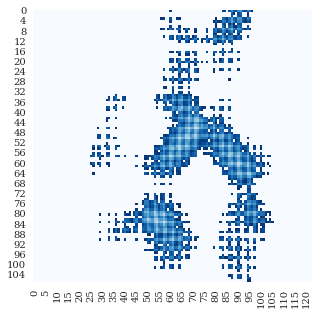

In [7]:
# PLOT
plt.figure(figsize=(5,5))
sns.heatmap(dist6d_12, cmap='Blues', cbar=False, vmin=0, vmax=20)

```python
from matplotlib.animation import FuncAnimation

titles = get_bins_tex(0.5, 0, 20, '$[20,+\infty)$', non_contact_at_first=False)
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_aspect('equal')
ax.set_title(titles[0])
cax = ax.pcolor(binned_dist6d_12[:, :, 0], vmin=0, vmax=1, cmap='Blues')
ax.invert_yaxis()
#fig.colorbar(cax)
def animate(i):
    ax.set_title(titles[i])
    cax.set_array(binned_dist6d_12[:, :, i].flatten())
anim = FuncAnimation(fig, animate, interval=150, frames=binned_dist6d_12.shape[2], repeat=True)
fig.show()
anim.save(f'./figs/{pdb_id}.{pdb_binary_int.chain_1.struct_asym_id}.{pdb_binary_int.chain_2.struct_asym_id}_dist6d_maps.gif', writer='pillow')
# ---
titles = get_bins_tex(0.5, 2, 20, non_contact_at_first=False)
fig, ax = plt.subplots(figsize=(6, 5))
ax.set_aspect('equal')
ax.set_title(titles[0])
cax = ax.pcolor(binned_dist6d_1[:, :, 0], vmin=0, vmax=1, cmap='Blues')
ax.invert_yaxis()
#fig.colorbar(cax)
def animate(i):
    ax.set_title(titles[i])
    cax.set_array(binned_dist6d_1[:, :, i].flatten())
anim = FuncAnimation(fig, animate, interval=150, frames=binned_dist6d_1.shape[2], repeat=True)
fig.show()
anim.save(f'./figs/{pdb_id}.{pdb_binary_int.chain_1.struct_asym_id}_dist6d_maps.gif', writer='pillow')

```
![fig1](./figs/3wwt.A.B_dist6d_maps.gif)
![fig1](./figs/3wwt.A_dist6d_maps.gif)

<AxesSubplot:>

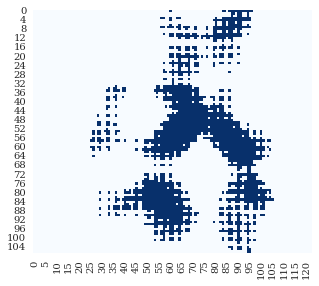

In [8]:
plt.figure(figsize=(5, 5))
sns.heatmap(binned_dist6d_12[:,:,:-1].sum(axis=2), cbar=False, square=True, cmap='Blues')

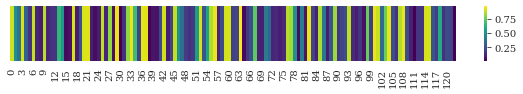

In [14]:
plt.figure(figsize=(10,1))
g = sns.heatmap([hydrophobic_preference(msa_obj_1['msa'])], cmap='viridis')
g.set_yticklabels([])
plt.show()